# HR Attrition Analysis & Predictive Modeling

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shap

# Set plot style
%matplotlib inline
sns.set_style('whitegrid')

## 2. Load and Inspect Data

In [2]:
# Load the dataset
try:
    df = pd.read_csv('../archive/WA_Fn-UseC_-HR-Employee-Attrition.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'WA_Fn-UseC_-HR-Employee-Attrition.csv' was not found in the 'archive' folder.")

# Display basic info and first few rows
print("\nData Info:")
df.info()

print("\n\nFirst 5 Rows:")
df.head()

Dataset loaded successfully!

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-nu

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## 3. Exploratory Data Analysis (EDA)

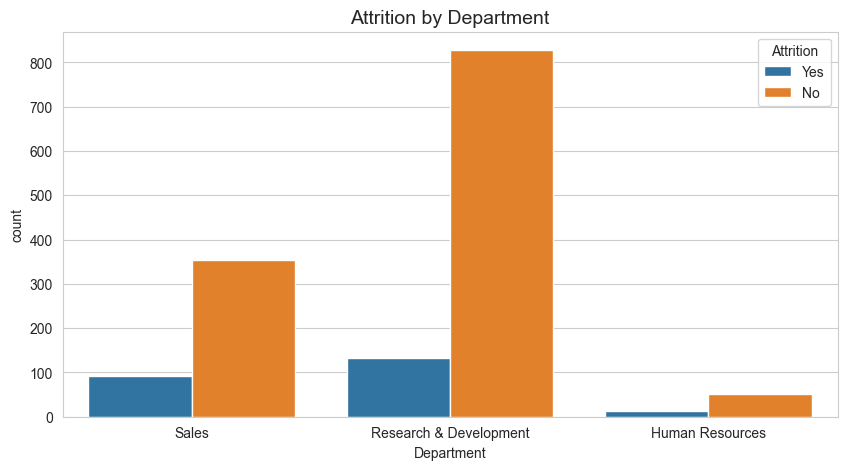

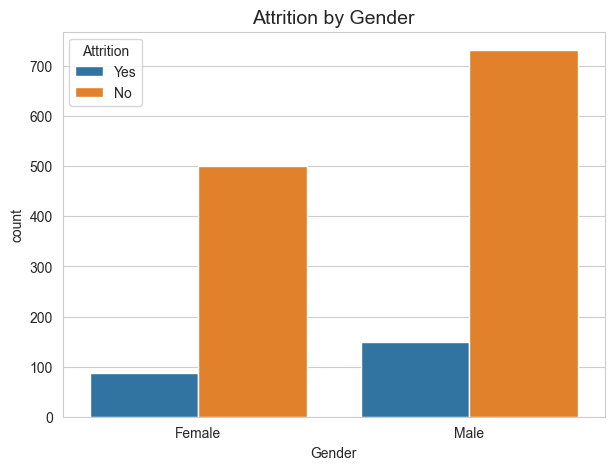

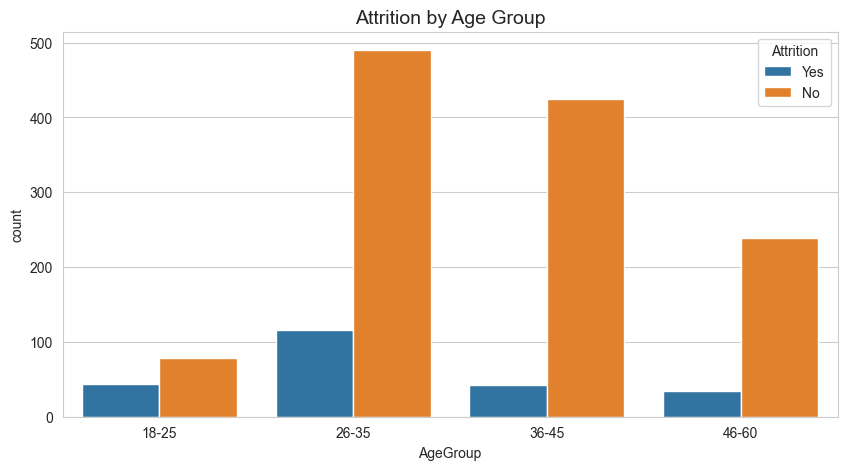

In [3]:
# Create AgeGroup for visualization
df['AgeGroup'] = pd.cut(df['Age'], bins=[17, 25, 35, 45, 60], labels=['18-25', '26-35', '36-45', '46-60'])

# --- Visualization 1: Attrition by Department ---
plt.figure(figsize=(10, 5))
sns.countplot(x='Department', hue='Attrition', data=df)
plt.title('Attrition by Department', fontsize=14)
plt.show()

# --- Visualization 2: Attrition by Gender ---
plt.figure(figsize=(7, 5))
sns.countplot(x='Gender', hue='Attrition', data=df)
plt.title('Attrition by Gender', fontsize=14)
plt.show()

# --- Visualization 3: Attrition by Age Group ---
plt.figure(figsize=(10, 5))
sns.countplot(x='AgeGroup', hue='Attrition', data=df)
plt.title('Attrition by Age Group', fontsize=14)
plt.show()

## 4. Prepare Data for Modeling

In [4]:
# Create a copy for modeling to keep the original df intact
df_model = df.copy()

# Drop the binned 'AgeGroup' column as it's redundant with 'Age'
df_model = df_model.drop('AgeGroup', axis=1)

# Apply LabelEncoder to all object/categorical columns
for column in df_model.columns:
    if df_model[column].dtype == 'object':
        le = LabelEncoder()
        df_model[column] = le.fit_transform(df_model[column])

print("Data after encoding:")
df_model.head()

Data after encoding:


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,1102,2,1,2,1,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,1,279,1,8,1,1,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,2,1373,1,2,2,4,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,1,1392,1,3,4,1,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,0,2,591,1,2,1,3,1,7,...,4,80,1,6,3,3,2,2,2,2


## 5. Build and Train the Classification Model

In [5]:
# Define features (X) and target (y)
X = df_model.drop('Attrition', axis=1)
y = df_model['Attrition']

# Split data into training and testing sets
# stratify=y ensures the proportion of attrition is the same in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Initialize and train the Logistic Regression model
# Increased max_iter to ensure the model converges
model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


## 6. Evaluate Model Performance (Deliverable)

Model Accuracy: 0.86

--- Classification Report ---

              precision    recall  f1-score   support

No Attrition       0.88      0.97      0.92       309
   Attrition       0.66      0.32      0.43        59

    accuracy                           0.86       368
   macro avg       0.77      0.64      0.68       368
weighted avg       0.85      0.86      0.84       368



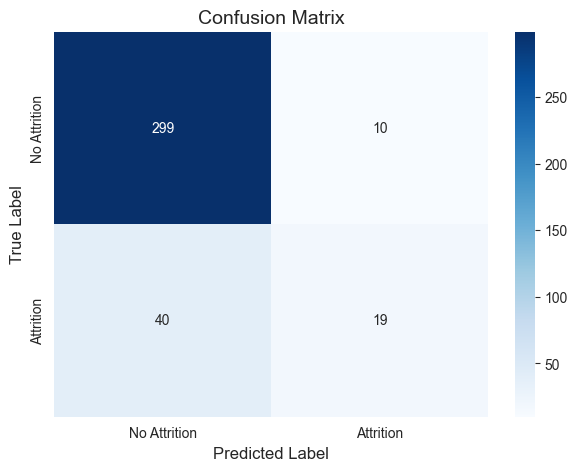

In [6]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# --- Model Accuracy Report ---
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')
print("\n--- Classification Report ---\n")
print(classification_report(y_test, y_pred, target_names=['No Attrition', 'Attrition']))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Attrition', 'Attrition'],
            yticklabels=['No Attrition', 'Attrition'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## 7. Explain Model Predictions with SHAP

SHAP Summary Plot (Top Factors Driving Attrition)


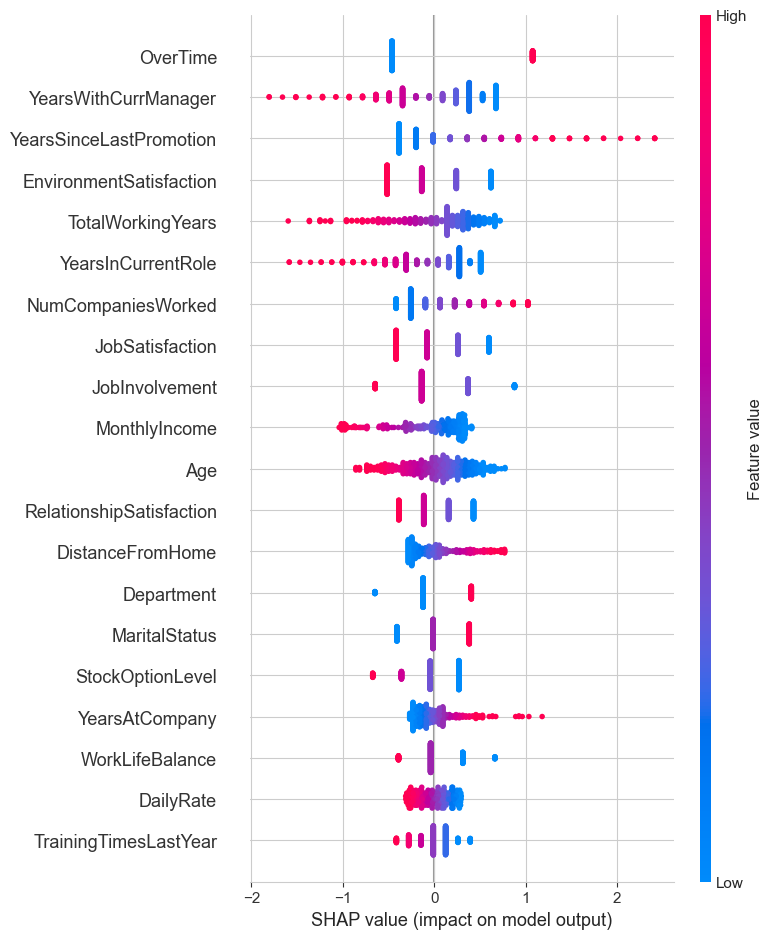

In [7]:
# SHAP requires a different explainer for linear models
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

print("SHAP Summary Plot (Top Factors Driving Attrition)")

# The summary plot shows feature importance and impact
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

## 8. Export Final Data for Power BI

In [8]:
# Predict attrition probability on the entire encoded dataset
full_dataset_probabilities = model.predict_proba(X)[:, 1] # Probability of Attrition = 'Yes'

# Add the probability score to the original, human-readable dataframe (df)
df['AttritionProbability'] = full_dataset_probabilities

# Export the final, enriched dataframe to a new CSV
output_path = '../archive/hr_data_with_predictions.csv'
df.to_csv(output_path, index=False)

print(f"Export complete. Enriched data saved to: {output_path}")
df.head()

Export complete. Enriched data saved to: ../archive/hr_data_with_predictions.csv


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AgeGroup,AttritionProbability
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,0,8,0,1,6,4,0,5,36-45,0.629629
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,1,10,3,3,10,7,1,7,46-60,0.013972
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,7,3,3,0,0,0,0,36-45,0.475118
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,0,8,3,3,8,7,3,0,26-35,0.145330
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,1,6,3,3,2,2,2,2,26-35,0.429604
